In [43]:
# dependency 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool,PanTool,WheelZoomTool,BoxZoomTool,ResetTool,UndoTool,RedoTool


# read the csv as df and add the new columns where county names without 'city' and 'county' is placed
df = pd.read_csv('DATA/main_cleaned.csv')
df.head()

,Unnamed: 0,Provider Id,Provider City,Provider State,Provider name,Hospital Ownership,Hospital overall rating,Average Total Payments,Average Medicare Payments,BEDS,Cost
0,0,10001,DOTHAN,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,5777.24,4763.73,420.0,1013.51
1,92,10001,DOTHAN,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,4894.76,3865.50,420.0,1029.26
2,184,10001,DOTHAN,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,10260.21,9167.08,420.0,1093.13
3,276,10001,DOTHAN,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,6542.08,5438.50,420.0,1103.58
4,368,10001,DOTHAN,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,4596.39,3618.93,420.0,977.46


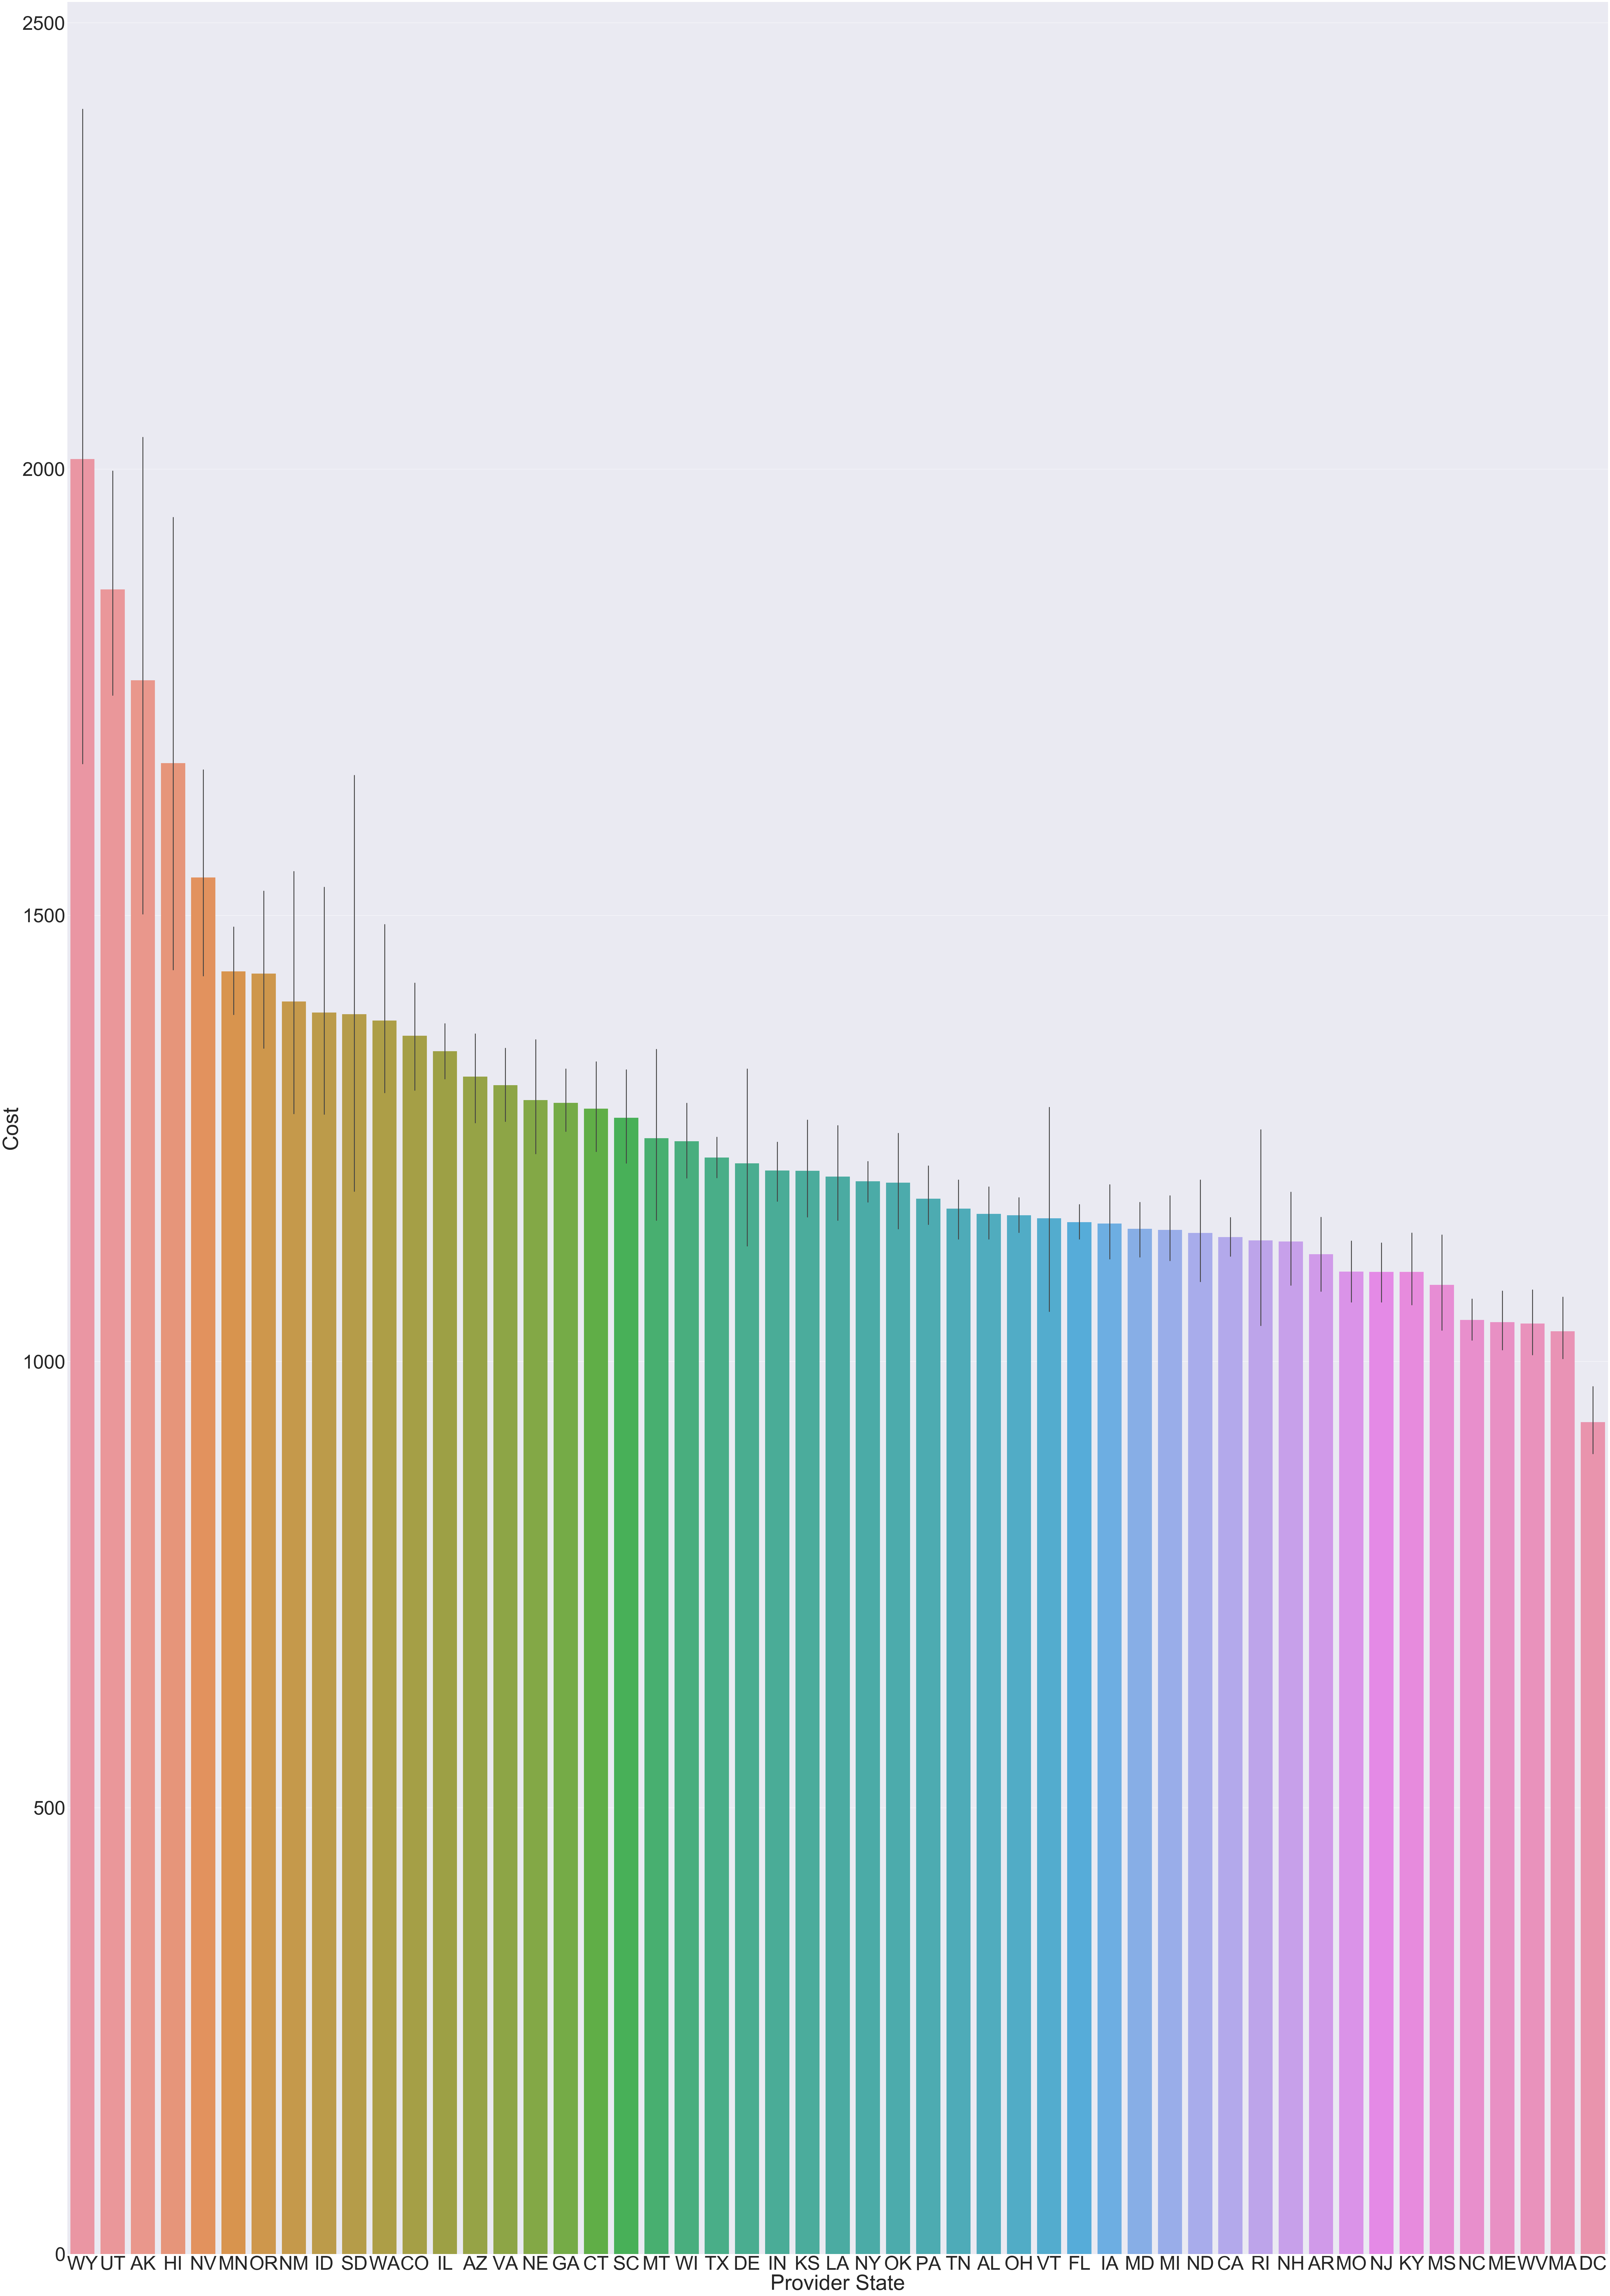

In [44]:
states = df.groupby('Provider State').mean().sort_values(by=['Cost'], ascending=False).index
sns.barplot(x='Provider State', y='Cost', data=df, order=states)
sns.set(rc={'figure.figsize':(100,150)}, font_scale=7)
plt.savefig('state_cost.png')
plt.show()

In [45]:
# sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=df, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.1})
# plt.ylim(0,)
# plt.xlim(0,)
# # plt.savefig('income_charge.png')
# plt.show()

In [46]:
# sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=df, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.1})
# plt.ylim(0,)
# plt.xlim(0,4000)
# # plt.savefig('income_charge.png')
# plt.show()

In [47]:
def showPlot(df, state, rating=[1,2,3,4,5]):
    if not 'Cost' in df.columns:
        print('dataframe must include "Cost" columns. Please check your dataframe!')
    elif not 'Hospital overall rating' in df.columns:
        print('dataframe must include "Hospital overall rating" columns. Please check your dataframe!')
    elif not 'Provider State':
        print('dataframe must include "Provider State" columns. Please check your dataframe!')
    elif not state in list(df['Provider State']):
        print('your state input might be wrong. please check your input!')
    elif not isinstance(rating, list) or len(rating)==0:
        print('rating must be a list contains more than one numeric element. please check your input!')
    else:
        dfbyState = df[df['Provider State'] == state]
        dfbyState_Rating = dfbyState[dfbyState["Hospital overall rating"].isin(rating)]
        sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=dfbyState_Rating, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.3})
        sns.set(font_scale=2)
        plt.ylim(0,)
        plt.xlim(0,4000)
        plt.title(f'Cost-Size relationship in {state}')
#         plt.savefig(f'cost_size_rating_in{state}.png')
        plt.show()

In [50]:
def f(STATE):
    showPlot(df,STATE)
states = df.groupby('Provider State').mean().index
ipywidgets.interact(f, STATE=states);

A Jupyter Widget

In [49]:
from IPython.display import display
import ipywidgets as widgets
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show
from bokeh.models import Range1d

states = df.groupby('Provider State').mean().index
d = widgets.Dropdown(options=states, value='CA')

# Event handler
def on_value_change(change):
    new_dfbyState = df[df['Provider State'] == change.new]
    new_dfbyState_Rating = new_dfbyState[new_dfbyState["Hospital overall rating"].isin([1,2,3,4,5])]
    x=new_dfbyState_Rating['Cost']
    y=new_dfbyState_Rating['BEDS']
    provider=new_dfbyState_Rating['Provider name']
    source.data=dict(x=x,y=y,desc=provider)
    push_notebook(handle=t)

d.observe(on_value_change, names='value')

hover = HoverTool(tooltips=[
    ("name:", "@desc"),
    ("cost:", "$x"),
    ("size:", "$y")    
])
pan = PanTool()
box = BoxZoomTool()
undo = UndoTool() 
redo = RedoTool()
reset = ResetTool()

fig = figure(width=640, height=400, tools=[hover,box,pan,undo,redo,reset], title='Cost-Size relationship')

dfbyState = df[df['Provider State'] == 'CA']
colors = ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']

for i in range(0,5):
    dfbyState_Rating = dfbyState[dfbyState["Hospital overall rating"].isin([i+1])]
    x = dfbyState_Rating['Cost']
    y = dfbyState_Rating['BEDS']
    provider = dfbyState_Rating['Provider name']
    source = ColumnDataSource(data=dict(x=x,y=y,desc=provider))
    r = fig.scatter("x", "y", source=source, color = colors[i], legend=str(i+1))
    
output_notebook()
display(d)
fig.title.text = "Rolling Standard Deviation"
fig.xaxis.axis_label = 'Cost'
fig.yaxis.axis_label = 'Size (Bed count)'
fig.x_range=Range1d(0,4000)
fig.y_range=Range1d(0,700)
t = show(fig, notebook_handle=True)

Loading BokehJS ...

A Jupyter Widget